In [1]:
# Bandits

In [2]:
import warnings ; warnings.filterwarnings('ignore')

import gym
import gym_bandits
import numpy as np
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

from itertools import cycle

import random
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')
matplotlib.rc('font', size=24)
matplotlib.rc('legend', fontsize=20)
matplotlib.rc('axes', titlesize=24)
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

np.set_printoptions(suppress=True)

# Baseline Strategies

In [3]:
def random_strategy(env, n_trials=50000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qt = np.empty((n_trials, env.action_space.n))
    returns = np.empty(n_trials)
    actions = np.empty(n_trials, dtype=np.int)
    name = 'Pure exploration'
    for t in tqdm(range(n_trials), desc='Trials for: ' + name, leave=False):
        action = np.random.randint(env.action_space.n)
        
        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qt[t] = Q
        returns[t] = reward
        actions[t] = action
    return name, returns, Qt, actions

In [4]:
def greedy_strategy(env, n_trials=50000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qt = np.empty((n_trials, env.action_space.n))
    returns = np.empty(n_trials)
    actions = np.empty(n_trials, dtype=np.int)
    name = 'Pure exploitation'
    for t in tqdm(range(n_trials), desc='Trials for: ' + name, leave=False):
        action = np.argmax(Q)

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qt[t] = Q
        returns[t] = reward
        actions[t] = action
    return name, returns, Qt, actions

# Simple Strategies

In [5]:
def e_greedy_strategy(env, 
                      epsilon=0.01, 
                      n_trials=50000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qt = np.empty((n_trials, env.action_space.n))
    returns = np.empty(n_trials)
    actions = np.empty(n_trials, dtype=np.int)
    name = 'E-greedy {}'.format(epsilon)
    for t in tqdm(range(n_trials), desc='Trials for: ' + name, leave=False):
        action = np.argmax(Q) if np.random.random() > epsilon else env.action_space.sample()

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qt[t] = Q
        returns[t] = reward
        actions[t] = action
    return name, returns, Qt, actions

In [21]:
def e_greedy_lin_decay_strategy(env,
                                init_epsilon=1.0,
                                min_epsilon=0.01, 
                                decay_ratio=0.05, 
                                n_trials=50000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qt = np.empty((n_trials, env.action_space.n))
    returns = np.empty(n_trials)
    actions = np.empty(n_trials, dtype=np.int)
    name = 'E-greedy lin {} {} {}'.format(init_epsilon, min_epsilon, decay_ratio)
    for t in tqdm(range(n_trials), desc='Trials for: ' + name, leave=False):
        decay_steps = n_trials * decay_ratio
        epsilon = 1 - t / decay_steps
        epsilon = (init_epsilon - min_epsilon) * epsilon + min_epsilon
        epsilon = np.clip(epsilon, min_epsilon, init_epsilon)
        action = np.argmax(Q) if np.random.random() > epsilon else env.action_space.sample()

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qt[t] = Q
        returns[t] = reward
        actions[t] = action
    return name, returns, Qt, actions

In [202]:
def e_greedy_exp_decay_strategy(env, 
                                init_epsilon=1.0,
                                min_epsilon=0.01,
                                decay_ratio=0.1,
                                n_trials=50000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qt = np.empty((n_trials, env.action_space.n))
    returns = np.empty(n_trials)
    actions = np.empty(n_trials, dtype=np.int)

    decay_steps = int(n_trials * decay_ratio)
    rem_steps = n_trials - decay_steps
    epsilons = 0.01
    epsilons /= np.logspace(-2, 0,decay_steps)
    epsilons *= init_epsilon-min_epsilon
    epsilons += min_epsilon
    epsilons = np.pad(epsilons, (0, rem_steps), 'edge')

    name = 'E-greedy exp {} {} {}'.format(init_epsilon, min_epsilon, decay_ratio)
    for t in tqdm(range(n_trials), desc='Trials for: ' + name, leave=False):
        action = np.argmax(Q) if np.random.random() > epsilons[t] else env.action_space.sample()

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qt[t] = Q
        returns[t] = reward
        actions[t] = action
    return name, returns, Qt, actions

In [203]:
def optimistic_strategy(env, 
                        optimistic_estimate=1.0,
                        initial_count=100,
                        n_trials=50000):
    Q = np.full((env.action_space.n), optimistic_estimate, dtype=np.float64)
    N = np.full((env.action_space.n), initial_count, dtype=np.float64)
    
    Qt = np.empty((n_trials, env.action_space.n))
    returns = np.empty(n_trials)
    actions = np.empty(n_trials, dtype=np.int)
    name = 'Optimistic {} {}'.format(optimistic_estimate, initial_count)
    for t in tqdm(range(n_trials), desc='Trials for: ' + name, leave=False):
        action = np.argmax(Q)

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]

        Qt[t] = Q
        returns[t] = reward
        actions[t] = action
    return name, returns, Qt, actions

# MDP

In [204]:
b2_Vs = []
for seed in [12, 34, 56, 78, 90]:
    env_name = 'BanditTwoArmedUniform-v0'
    np.random.seed(seed) ; random.seed(seed) ; env = gym.make(env_name) ; env.seed(seed) ; env.reset()
    b2_Q = np.array(env.env.p_dist * env.env.r_dist)
    print('2-armed bandit with seed', seed)
    print('Probability of reward:', env.env.p_dist)
    print('Reward:', env.env.r_dist)
    print('Q(.):', b2_Q)
    b2_Vs.append(np.max(b2_Q))
    print('V*:', b2_Vs[-1])
    print()

2-armed bandit with seed 12
Probability of reward: [0.15416284 0.7400497 ]
Reward: [1 1]
Q(.): [0.15416284 0.7400497 ]
V*: 0.7400496965154048

2-armed bandit with seed 34
Probability of reward: [0.03856168 0.78010046]
Reward: [1 1]
Q(.): [0.03856168 0.78010046]
V*: 0.780100460524675

2-armed bandit with seed 56
Probability of reward: [0.98419185 0.33341227]
Reward: [1 1]
Q(.): [0.98419185 0.33341227]
V*: 0.9841918505425767

2-armed bandit with seed 78
Probability of reward: [0.04818123 0.68096301]
Reward: [1 1]
Q(.): [0.04818123 0.68096301]
V*: 0.6809630138677178

2-armed bandit with seed 90
Probability of reward: [0.1530542  0.15768566]
Reward: [1 1]
Q(.): [0.1530542  0.15768566]
V*: 0.15768566100940729



# Running simple strategies

In [225]:
def b2_run_simple_strategies_experiment(env_name):
    results = {}
    # for seed in tqdm([12, 34, 56, 78, 90], desc='All experiments'):
    for seed in tqdm([12, 34, 56], desc='All experiments'):
        experiments = [
            # baseline strategies
            lambda env: random_strategy(env), 
            lambda env: greedy_strategy(env),

            # epsilon greedy
            lambda env: e_greedy_strategy(env, epsilon=0.006),
            lambda env: e_greedy_strategy(env, epsilon=0.01),

            # epsilon greedy linearly decaying
            lambda env: e_greedy_lin_decay_strategy(env, init_epsilon=1.0, min_epsilon=0.0, decay_ratio=0.002),
            lambda env: e_greedy_lin_decay_strategy(env, init_epsilon=0.4, min_epsilon=0.0001, decay_ratio=0.006),

            # epsilon greedy exponentially decaying
            lambda env: e_greedy_exp_decay_strategy(env, init_epsilon=1.0, min_epsilon=0.0001, decay_ratio=0.001),
            lambda env: e_greedy_exp_decay_strategy(env, init_epsilon=0.5, min_epsilon=0.0, decay_ratio=0.003),

            # optimistic
            lambda env: optimistic_strategy(env, optimistic_estimate=0.5, initial_count=1000),
            lambda env: optimistic_strategy(env, optimistic_estimate=1.0, initial_count=50),
        ]
        for experiment in tqdm(experiments, desc='Experiments with seed {}'.format(seed), leave=False):
            np.random.seed(seed) ; random.seed(seed) ; env = gym.make(env_name) ; env.seed(seed) ; env.reset()    
            name, Rt, Qt, At = experiment(env)
            At = np.expand_dims(At, -1)
            true_Q = np.array(env.env.p_dist * env.env.r_dist)
            opt_V = np.max(true_Q)
            trial_mean_rew = np.cumsum(Rt) / (np.arange(len(Rt)) + 1)
            Q_selected = np.take_along_axis(np.tile(true_Q, At.shape), At, axis=1).squeeze()
            regret = opt_V - Q_selected
            cum_regret = np.cumsum(regret)
            if name not in results.keys(): results[name] = {}
            if 'Rt' not in results[name].keys(): results[name]['Rt'] = []
            if 'Qt' not in results[name].keys(): results[name]['Qt'] = []
            if 'At' not in results[name].keys(): results[name]['At'] = []
            if 'cum_regret' not in results[name].keys(): results[name]['cum_regret'] = []
            if 'trial_mean_rew' not in results[name].keys(): results[name]['trial_mean_rew'] = []
            
            results[name]['Rt'].append(Rt)
            results[name]['Qt'].append(Qt)
            results[name]['At'].append(At)
            results[name]['cum_regret'].append(cum_regret)
            results[name]['trial_mean_rew'].append(trial_mean_rew)
    return results

b2_results_s = b2_run_simple_strategies_experiment('BanditTwoArmedUniform-v0')

# Plotting results of simple strategies on 2-arm bandit

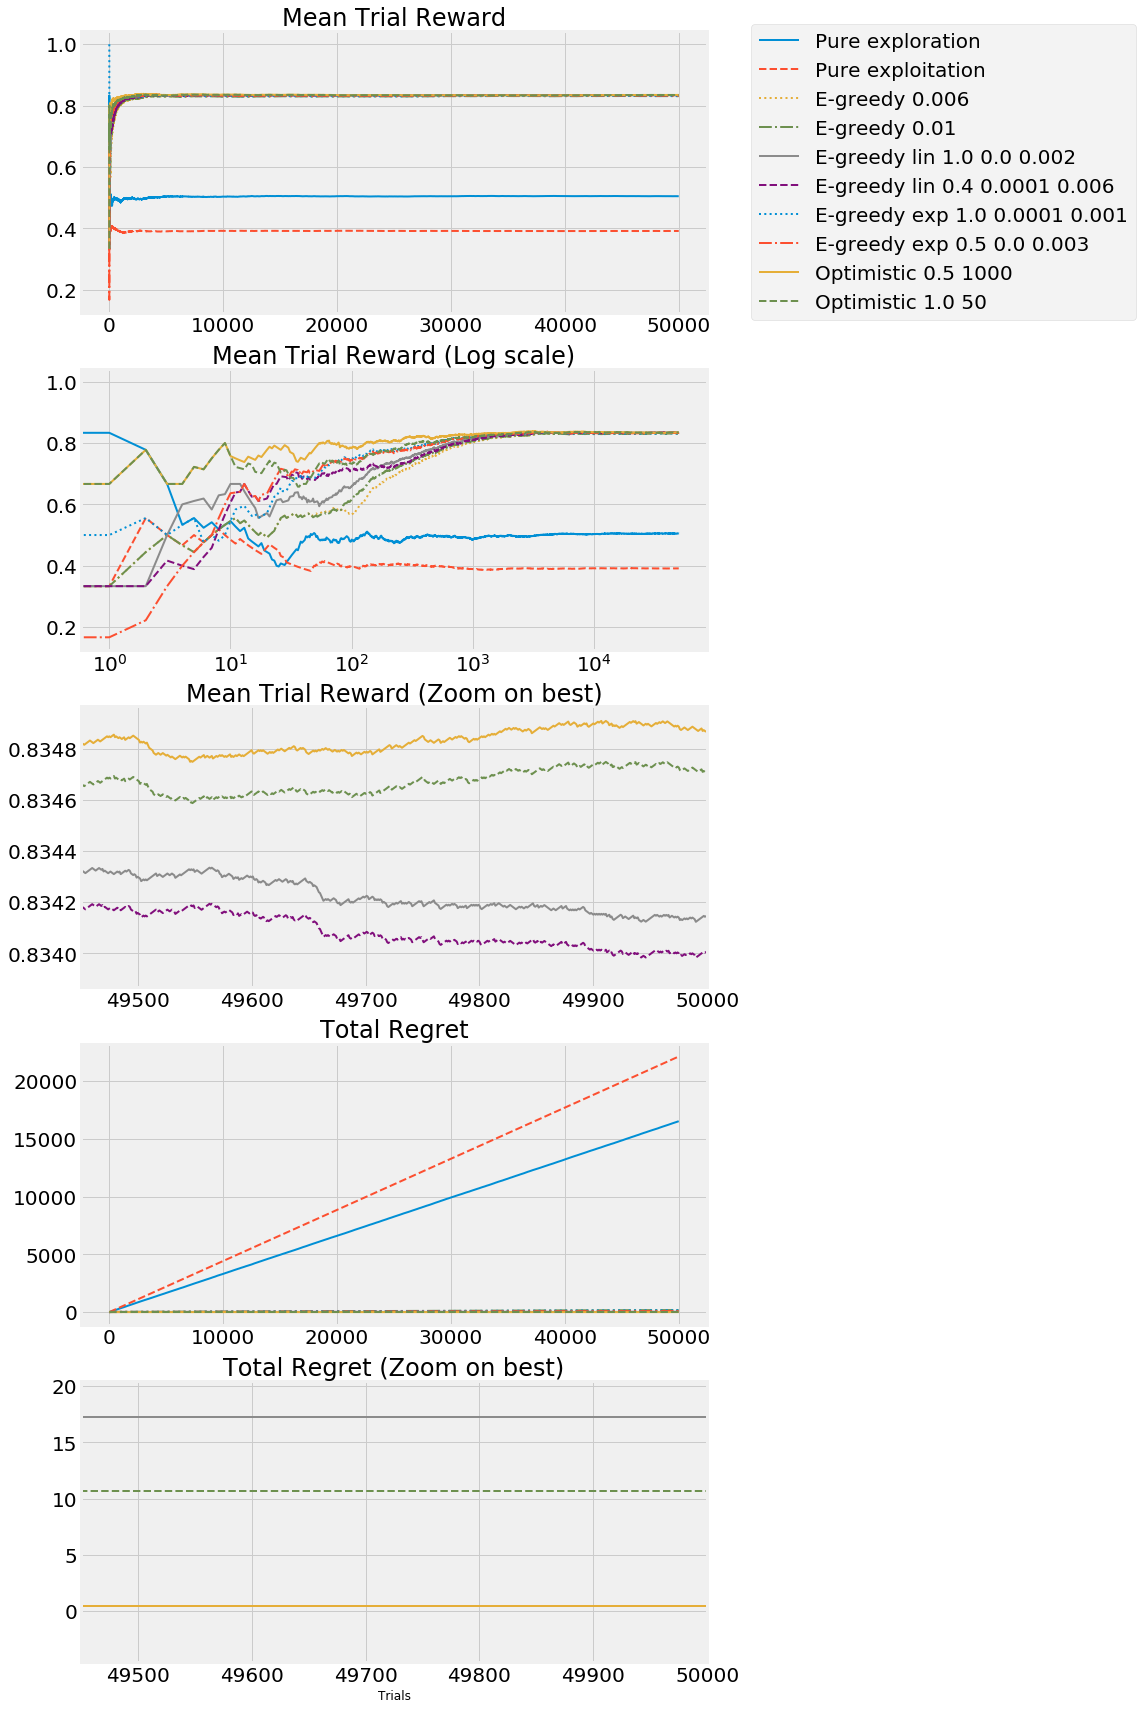

In [226]:
fig, axs = plt.subplots(5, 1, figsize=(10, 30), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b2_results_s.items():
    color = next(linecycler)

    # reward
    trial_mean_rew = np.array(result['trial_mean_rew'])
    mean_trial_mean_rew = np.mean(trial_mean_rew, axis=0)

    axs[0].plot(mean_trial_mean_rew, color, linewidth=2, label=label)

    axs[1].plot(mean_trial_mean_rew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(mean_trial_mean_rew, color, linewidth=2, label=label)
    if max_ret < mean_trial_mean_rew[-1]: max_ret = mean_trial_mean_rew[-1]
    axs[2].axis((A.shape[1]*0.989,A.shape[1],max_ret-0.001,max_ret+0.0001))

    # regret
    cum_regret = np.array(result['cum_regret'])
    mean_cum_regret = np.mean(cum_regret, axis=0)

    axs[3].plot(mean_cum_regret, color, linewidth=2, label=label)
    
    axs[4].plot(mean_cum_regret, color, linewidth=2, label=label)
    if min_reg > mean_cum_regret[-1]: min_reg = mean_cum_regret[-1]
    plt.axis((A.shape[1]*0.989,A.shape[1],min_reg-5,min_reg+20))

    # config plot
    axs[0].set_title('Mean Trial Reward')
    axs[1].set_title('Mean Trial Reward (Log scale)')
    axs[2].set_title('Mean Trial Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Trials')
    axs[0].legend(loc='center right', bbox_to_anchor=(1.7, 0.5))
plt.show()    

# 10-armed Bandit (Gaussian)

In [ ]:
b10_results_s = run_simple_strategies_experiment('BanditTenArmedGaussian-v0')

# MDP

In [ ]:
np.random.seed(12345) ; env = gym.make('BanditTenArmedGaussian-v0') ; env.reset()
b10_true_Q = np.expand_dims(np.array(env.env.r_dist), -1)[:,0,:].flatten()
print('Probability of reward:')
print(env.env.p_dist)
print('Reward:')
pprint(env.env.r_dist)
print('Q:')
print(b10_true_Q)
print('V*:')
print(np.max(b10_true_Q))

# Plotting Results

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(10, 30), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b10_results_s.items():
    R = np.array(result['Rt'])
    Q = np.array(result['Qt'])
    A = np.array(result['At'])
    color = next(linecycler)

    cumrew = np.mean(np.cumsum(R, axis=1)/(np.arange(A.shape[1])+1), axis=0)
    axs[0].plot(cumrew, color, linewidth=2, label=label)

    axs[1].plot(cumrew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(cumrew, color, linewidth=2, label=label)
    if max_ret < cumrew[-1]: max_ret = cumrew[-1]
    axs[2].axis((A.shape[1]*0.989,A.shape[1],max_ret-0.01,max_ret+0.01))
    
    A = np.expand_dims(A,-1)
    selected = np.take_along_axis(np.tile(b10_true_Q, A.shape), A, axis=2).squeeze()
    regret = np.cumsum(np.max(b10_true_Q) - selected, axis=1)
    regret = np.mean(regret, axis=0)
    axs[3].plot(regret, color, linewidth=2, label=label)
    
    axs[4].plot(regret, color, linewidth=2, label=label)
    if min_reg > regret[-1]: min_reg = regret[-1]
    plt.axis((A.shape[1]*0.989,A.shape[1],min_reg-5,min_reg+20))

    axs[0].set_title('Mean Trial Reward')
    axs[1].set_title('Mean Trial Reward (Log scale)')
    axs[2].set_title('Mean Trial Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Trials')
    axs[0].legend(loc='center right', bbox_to_anchor=(1.7, 0.5))
plt.show()    

# Advanced Strategies

In [ ]:
def softmax(env, init_temp=1.0, min_temp=0.3, decay_ratio=0.04, n_trials=50000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qt = np.empty((n_trials, env.action_space.n))
    returns = np.empty(n_trials)
    actions = np.empty(n_trials, dtype=np.int)
    name = 'SoftMax {} {} {}'.format(init_temp, min_temp, decay_ratio)
    for t in tqdm(range(n_trials), desc='Trials for: ' + name, leave=False):
        decay_steps = n_trials * decay_ratio
        temp = 1 - t / decay_steps
        temp = (init_temp - min_temp) * temp + min_temp
        temp = np.clip(temp, min_temp, init_temp)

        scaled_Q = Q/temp
        norm_Q = scaled_Q - scaled_Q.max()
        e = np.exp(norm_Q)
        probs = e / np.sum(e)
        assert np.isclose(probs.sum(), 1.0)
        action = np.random.choice(np.arange(len(probs)), size=1, p=probs)[0]

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qt[t] = Q
        returns[t] = reward
        actions[t] = action
    return name, returns, Qt, actions

In [ ]:
def upper_confidence_bound(env, c=2, n_trials=50000):
    Q = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))

    Qt = np.empty((n_trials, env.action_space.n))
    returns = np.empty(n_trials)
    actions = np.empty(n_trials, dtype=np.int)
    name = 'UCB {}'.format(c)
    for t in tqdm(range(n_trials), desc='Trials for: ' + name, leave=False):
        action = t
        if t >= len(Q):
            U = np.sqrt(c * np.log(t)/N)
            action = np.argmax(Q + U)

        _, reward, _, _ = env.step(action)
        N[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/N[action]
        
        Qt[t] = Q
        returns[t] = reward
        actions[t] = action
    return name, returns, Qt, actions

In [ ]:
def bayesian(env, tau=1, n_trials=50000):
    Q = np.zeros((env.action_space.n))
    QN = np.zeros((env.action_space.n))
    R = np.zeros((env.action_space.n))
    N = np.zeros((env.action_space.n))
    means = np.zeros((env.action_space.n))
    
    Qt = np.empty((n_trials, env.action_space.n))
    returns = np.empty(n_trials)
    actions = np.empty(n_trials, dtype=np.int)
    name = 'Bayesian {}'.format(tau)
    for t in tqdm(range(n_trials), desc='Trials for: ' + name, leave=False):
        action = t
        if t >= len(N):
            action = np.argmax(np.random.randn() / np.sqrt(N) + means)

        _, reward, _, _ = env.step(action)
        R[action] += reward
        N[action] += tau
        means[action] = tau * R[action] / N[action]
        
        QN[action] += 1
        Q[action] = Q[action] + (reward - Q[action])/QN[action]

        Qt[t] = Q
        returns[t] = reward
        actions[t] = action
    return name, returns, Qt, actions

# Run advanced strategies

In [ ]:
def run_advanced_strategies_experiment(env_name):
    results = {}
    for seed in tqdm([12, 34, 56, 78, 90], desc='All experiments'):
        experiments = [
            # baseline strategies
            # lambda env: random_strategy(env), 
            # lambda env: greedy_strategy(env),
            
            # best (from simple) epsilon greedy linearly decaying
            # lambda env: e_greedy_lin_decay_strategy(env, init_epsilon=1.0, min_epsilon=0.001, decay_ratio=0.002),

            # best (from simple) optimistic
            lambda env: optimistic_strategy(env, optimistic_estimate=0.9, initial_count=10),

            # softmax
            # lambda env: softmax(env, init_temp=1.0, min_temp=0.001, decay_ratio=0.01),
            # lambda env: softmax(env, init_temp=1.0, min_temp=0.05, decay_ratio=0.001),

            # ucb
            lambda env: upper_confidence_bound(env, c=0.1),
            lambda env: upper_confidence_bound(env, c=0.2),
            lambda env: upper_confidence_bound(env, c=0.3),
            lambda env: upper_confidence_bound(env, c=0.5),
            lambda env: upper_confidence_bound(env, c=1.0),
            lambda env: upper_confidence_bound(env, c=2.0),
            lambda env: upper_confidence_bound(env, c=3.0),
            lambda env: upper_confidence_bound(env, c=5.0),

            # bayesian
            # lambda env: bayesian(env, tau=5),
            # lambda env: bayesian(env, tau=10),
        ]
        for experiment in tqdm(experiments, desc='Experiments with seed {}'.format(seed), leave=False):
            np.random.seed(seed) ; random.seed(seed) ; env = gym.make(env_name) ; env.reset()
            name, Rt, Qt, At = experiment(env)
            if name not in results.keys(): results[name] = {}
            if 'Rt' not in results[name].keys(): results[name]['Rt'] = []
            if 'Qt' not in results[name].keys(): results[name]['Qt'] = []
            if 'At' not in results[name].keys(): results[name]['At'] = []
            
            results[name]['Rt'].append(Rt)
            results[name]['Qt'].append(Qt)
            results[name]['At'].append(At)
    return results

# 2-armed Bandit

In [ ]:
b2_results_a = run_advanced_strategies_experiment('BanditTwoArmedHighHighFixed-v0')

# Plotting Results

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(10, 30), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b2_results_a.items():
    R = np.array(result['Rt'])
    Q = np.array(result['Qt'])
    A = np.array(result['At'])
    color = next(linecycler)

    cumrew = np.mean(np.cumsum(R, axis=1)/(np.arange(A.shape[1])+1), axis=0)
    axs[0].plot(cumrew, color, linewidth=2, label=label)

    axs[1].plot(cumrew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(cumrew, color, linewidth=2, label=label)
    if max_ret < cumrew[-1]: max_ret = cumrew[-1]
    axs[2].axis((A.shape[1]*0.989,A.shape[1],max_ret-0.001,max_ret+0.0001))
    
    A = np.expand_dims(A,-1)
    selected = np.take_along_axis(np.tile(b2_true_Q, A.shape), A, axis=2).squeeze()
    regret = np.cumsum(np.max(b2_true_Q) - selected, axis=1)
    regret = np.mean(regret, axis=0)
    axs[3].plot(regret, color, linewidth=2, label=label)
    
    axs[4].plot(regret, color, linewidth=2, label=label)
    if min_reg > regret[-1]: min_reg = regret[-1]
    plt.axis((A.shape[1]*0.989,A.shape[1],min_reg-5,min_reg+20))

    axs[0].set_title('Mean Trial Reward')
    axs[1].set_title('Mean Trial Reward (Log scale)')
    axs[2].set_title('Mean Trial Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Trials')
    axs[0].legend(loc='center right', bbox_to_anchor=(1.7, 0.5))
plt.show()    

# 10-armed Bandit (Gaussian)

In [ ]:
b10_results_a = run_advanced_strategies_experiment('BanditTenArmedGaussian-v0')

3.6084143362321077


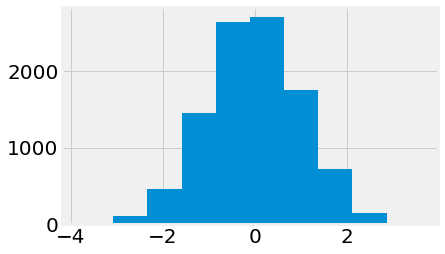

In [269]:
s = [np.random.normal(0, 1) for _ in range(10000)]
plt.hist(s)
print(np.max(s))

# Plotting Results

In [ ]:
fig, axs = plt.subplots(5, 1, figsize=(10, 30), sharey=False, sharex=False)

lines = ["-","--",":","-."]
linecycler = cycle(lines)
min_reg, max_ret = float('inf'), float('-inf')
for label, result in b10_results_a.items():
    R = np.array(result['Rt'])
    Q = np.array(result['Qt'])
    A = np.array(result['At'])
    color = next(linecycler)

    cumrew = np.mean(np.cumsum(R, axis=1)/(np.arange(A.shape[1])+1), axis=0)
    axs[0].plot(cumrew, color, linewidth=2, label=label)

    axs[1].plot(cumrew, color, linewidth=2, label=label)
    axs[1].set_xscale('log')
    
    axs[2].plot(cumrew, color, linewidth=2, label=label)
    if max_ret < cumrew[-1]: max_ret = cumrew[-1]
    axs[2].axis((A.shape[1]*0.989,A.shape[1],max_ret-0.01,max_ret+0.0001))
    
    A = np.expand_dims(A,-1)
    selected = np.take_along_axis(np.tile(b10_true_Q, A.shape), A, axis=2).squeeze()
    regret = np.cumsum(np.max(b10_true_Q) - selected, axis=1)
    regret = np.mean(regret, axis=0)
    axs[3].plot(regret, color, linewidth=2, label=label)
    
    axs[4].plot(regret, color, linewidth=2, label=label)
    if min_reg > regret[-1]: min_reg = regret[-1]
    plt.axis((A.shape[1]*0.989,A.shape[1],min_reg-5,min_reg+20))

    axs[0].set_title('Mean Trial Reward')
    axs[1].set_title('Mean Trial Reward (Log scale)')
    axs[2].set_title('Mean Trial Reward (Zoom on best)')
    axs[3].set_title('Total Regret')
    axs[4].set_title('Total Regret (Zoom on best)')
    plt.xlabel('Trials')
    axs[0].legend(loc='center right', bbox_to_anchor=(1.7, 0.5))

plt.show()